## <center> Прогнозирование задержек вылетов

Ваша задача – побить единственный бенчмарк в [соревновании](https://www.kaggle.com/c/flight-delays-2017) на Kaggle Inclass. Подробных инструкций не будет, будет только тезисно описано, как получен этот бенчмарк. Конечно, с помощью Xgboost. Надеюсь, на данном этапе курса вам достаточно бросить полтора взгляда на данные, чтоб понять, что это тот тип задачи, в которой затащит Xgboost. Но проверьте еще Catboost.

In [1]:
#pip install xgboost

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score


In [59]:
train = pd.read_csv('flight-delays-2017/flight_delays_train.csv')
test = pd.read_csv('flight-delays-2017/flight_delays_test.csv')

train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  object
 1   DayofMonth         100000 non-null  object
 2   DayOfWeek          100000 non-null  object
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB


In [60]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Month          100000 non-null  object
 1   DayofMonth     100000 non-null  object
 2   DayOfWeek      100000 non-null  object
 3   DepTime        100000 non-null  int64 
 4   UniqueCarrier  100000 non-null  object
 5   Origin         100000 non-null  object
 6   Dest           100000 non-null  object
 7   Distance       100000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 6.1+ MB


In [5]:
#fill "nan"
#train.fillna(0, inplace = True)
#test.fillna(0, inplace = True)

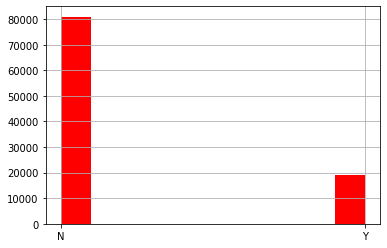

In [61]:
#transform data 'y' type 'object' in 'binary'
y = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
print(train['dep_delayed_15min'].value_counts(normalize=True))
train.drop(['dep_delayed_15min'], inplace = True, axis = 1)

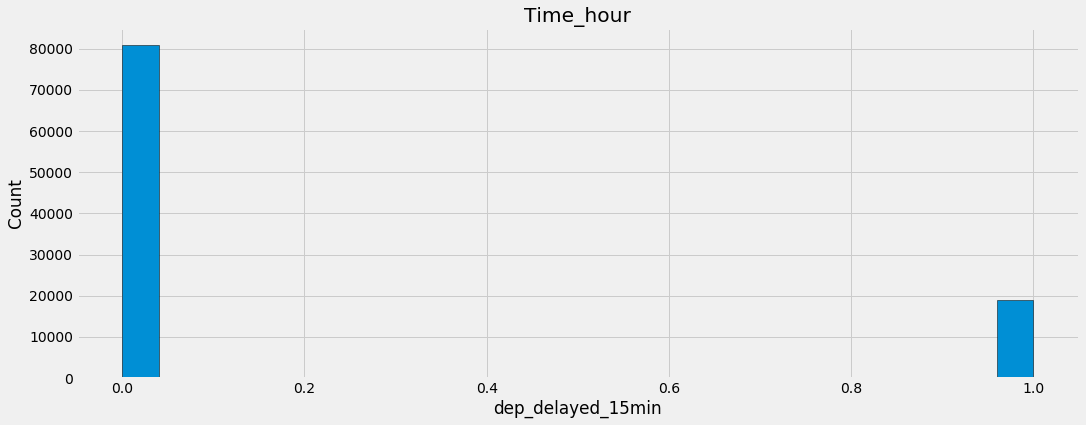

In [128]:
#look at the dep delayed 15min
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,6))
# Plot the distribution of ages in years
plt.hist(y, edgecolor = 'k', bins = 25)
plt.title('dep_delayed_15min'); plt.xlabel('dep_delayed_15min'); plt.ylabel('Count');

In [65]:
train.describe()

,DepTime,Distance
count,100000.000000,100000.00000
mean,1341.523880,729.39716
std,476.378445,574.61686
min,1.000000,30.00000
25%,931.000000,317.00000
50%,1330.000000,575.00000
75%,1733.000000,957.00000
max,2534.000000,4962.00000


In [66]:
#clean data
def clean_data(t):
    t['DayofMonth'] = t['DayofMonth'].apply(lambda x: int(x.split('-')[1]))
    t['Month'] = t['Month'].apply(lambda x: int(x.split('-')[1]))
    t['DayOfWeek'] = t['DayOfWeek'].apply(lambda x: int(x.split('-')[1]))
    t['Time_hour'] = t['DepTime'].apply(lambda x: int(x/60))
    t['Time_day'] = t['DepTime'].apply(lambda x: round(x/60/24, 0))

clean_data(train)
clean_data(test)

In [67]:
#new feature for test
# Select numerical columns
def new_feature(t):
    t['weekday'] =(t['DayOfWeek']  >= 6).astype('int')
    t['workday'] =(t['DayOfWeek']  < 6).astype('int')
       #season
    t['spring'] = ((t['Month'] >= 3) & (t['Month'] < 6)).astype('int')
    t['summer'] = ((t['Month'] >= 6) & (t['Month'] < 9)).astype('int')
    t['autumn'] = ((t['Month'] >= 9) & (t['Month'] < 12)).astype('int')
    t['winter'] = ((t['Month']>= 12) & (t['Month'] < 3)).astype('int')
    
new_feature(test)
new_feature(train)

In [68]:
train.head(3)

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,Time_hour,Time_day,weekday,workday,spring,summer,autumn,winter
0,8,21,7,1934,AA,ATL,DFW,732,32,1.0,1,0,0,1,0,0
1,4,20,3,1548,US,PIT,MCO,834,25,1.0,0,1,1,0,0,0
2,9,2,5,1422,XE,RDU,CLE,416,23,1.0,0,1,0,0,1,0


In [69]:
test.tail(3)

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,Time_hour,Time_day,weekday,workday,spring,summer,autumn,winter
99997,1,30,2,1509,OO,ORD,SGF,438,25,1.0,0,1,0,0,0,0
99998,1,5,5,804,DL,LGA,ATL,761,13,1.0,0,1,0,0,0,0
99999,10,29,1,834,OO,MKE,MSP,297,13,1.0,0,1,0,0,1,0


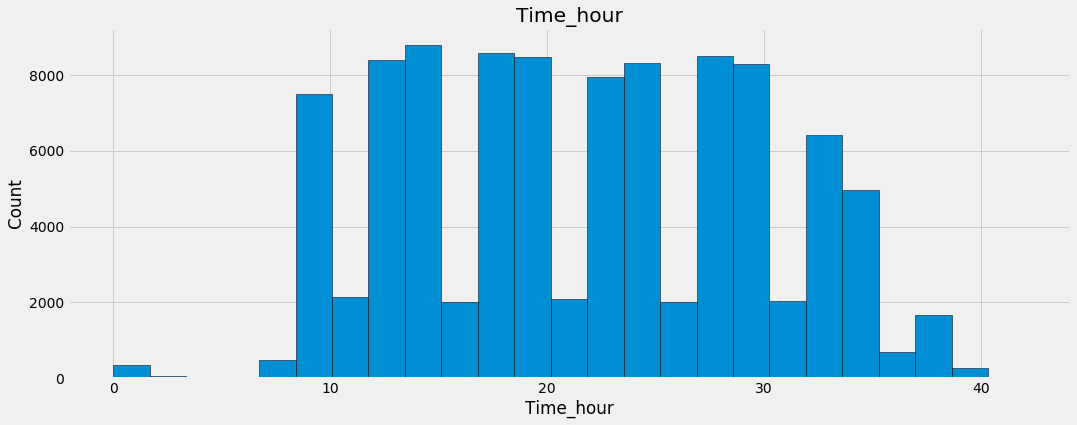

In [118]:
#look at the data
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,6))
# Plot the distribution of ages in years
plt.hist(train['Time_hour'], edgecolor = 'k', bins = 25)
plt.title('Time_hour'); plt.xlabel('Time_hour'); plt.ylabel('Count');

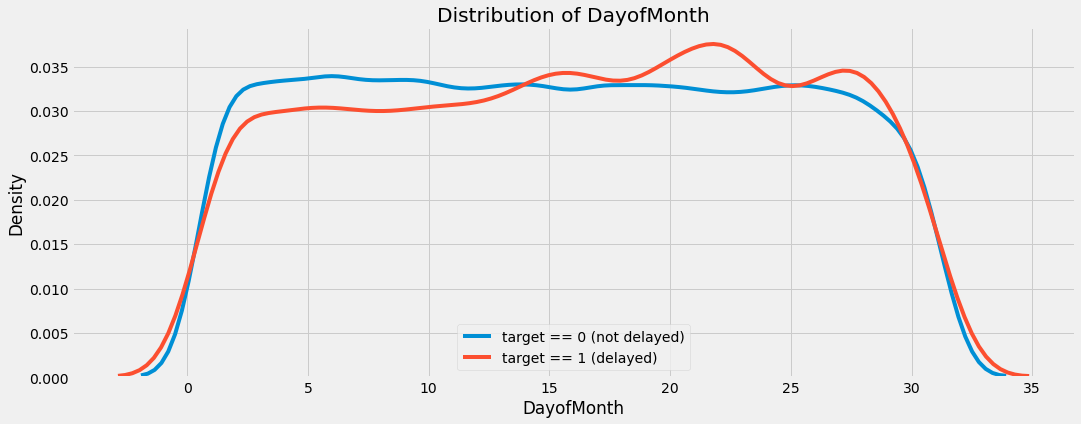

In [127]:
plt.figure(figsize = (16, 6))

# KDE plot of loans that were repaid on time
sns.kdeplot(train.loc[y== 0, 'DayofMonth'], label = 'target == 0 (not delayed)')

# KDE plot of loans which were not repaid on time
sns.kdeplot(train.loc[y== 1, 'DayofMonth'], label = 'target == 1 (delayed)')

# Labeling of plot
plt.xlabel('DayofMonth'); plt.ylabel('Density'); plt.title('Distribution of DayofMonth');

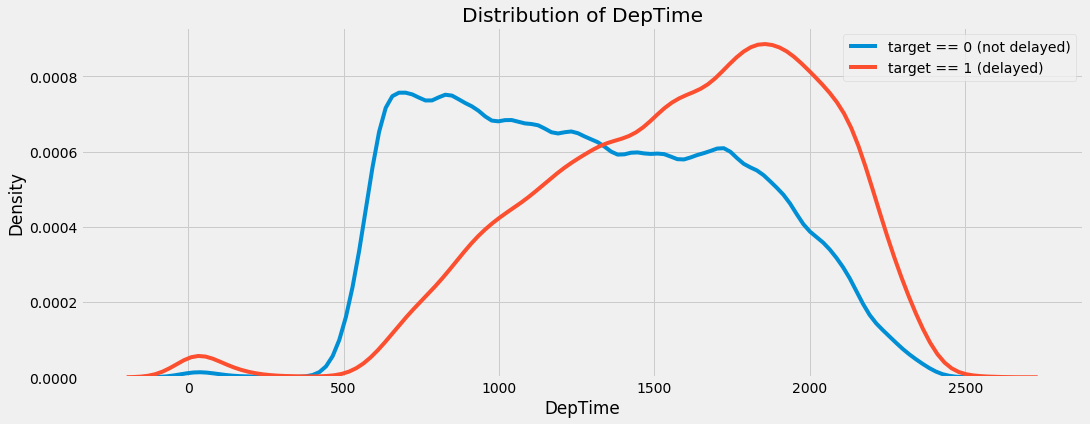

In [126]:
plt.figure(figsize = (16, 6))

# KDE plot of loans that were repaid on time
sns.kdeplot(train.loc[y== 0, 'DepTime'], label = 'target == 0 (not delayed)')

# KDE plot of loans which were not repaid on time
sns.kdeplot(train.loc[y== 1, 'DepTime'], label = 'target == 1 (delayed)')

# Labeling of plot
plt.xlabel('DepTime'); plt.ylabel('Density'); plt.title('Distribution of DepTime');
#The target == 1 curve skews towards the end of the range

In [70]:
# Select numerical, columns
numerical_cols = [cname for cname in train.columns if train[cname].dtype in ['int', 'float']]
categorial_cols = [cname for cname in train.columns if train[cname].dtype in ['object']]

numerical_cols,  categorial_cols

#check the number of columns in the train/test data
train.columns == test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [71]:
test_categorial = pd.get_dummies(test[categorial_cols], drop_first=False)
train_categorial = pd.get_dummies(train[categorial_cols], drop_first=False)
test

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,Time_hour,Time_day,weekday,workday,spring,summer,autumn,winter
0,7,25,3,615,YV,MRY,PHX,598,10,0.0,0,1,0,1,0,0
1,4,17,2,739,WN,LAS,HOU,1235,12,1.0,0,1,1,0,0,0
2,12,2,7,651,MQ,GSP,ORD,577,10,0.0,1,0,0,0,0,0
3,3,25,7,1614,WN,BWI,MHT,377,26,1.0,1,0,1,0,0,0
4,6,6,3,1505,UA,ORD,STL,258,25,1.0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,6,5,2,852,WN,CRP,HOU,187,14,1.0,0,1,0,1,0,0
99996,11,24,6,1446,UA,ORD,LAS,1515,24,1.0,1,0,0,0,1,0
99997,1,30,2,1509,OO,ORD,SGF,438,25,1.0,0,1,0,0,0,0
99998,1,5,5,804,DL,LGA,ATL,761,13,1.0,0,1,0,0,0,0


In [72]:
train.drop(categorial_cols, inplace = True, axis = 1)
test.drop(categorial_cols, inplace = True, axis = 1)

In [73]:
#pd.concat([test[numerical_cols], test_categorial], axis='1')
#test.join(other
train = train.join(train_categorial)
test = test.join(test_categorial)

In [74]:
#drop different columns in data
different_columns_train=[a for a in train.columns if a not in test.columns]
print(different_columns_train)
train.drop(different_columns_train, inplace = True, axis = 1)
different_columns_test=[a for a in test.columns if a not in train.columns]
print(different_columns_test)
test.drop(different_columns_test, inplace = True, axis = 1)

['UniqueCarrier_DH', 'UniqueCarrier_HP', 'UniqueCarrier_TZ', 'Origin_CDC', 'Origin_HKY', 'Origin_HVN', 'Origin_ISO', 'Origin_PIE', 'Origin_VCT', 'Origin_VIS', 'Dest_CDC', 'Dest_GST', 'Dest_HKY', 'Dest_HVN', 'Dest_ISO', 'Dest_PIE', 'Dest_TEX', 'Dest_VCT', 'Dest_VIS']
['UniqueCarrier_9E', 'Origin_ALO', 'Origin_BJI', 'Origin_CMX', 'Origin_EAU', 'Origin_ELM', 'Origin_EWN', 'Origin_HHH', 'Origin_INL', 'Origin_MTH', 'Origin_PLN', 'Origin_PMD', 'Origin_RHI', 'Origin_ROW', 'Origin_SLE', 'Origin_SOP', 'Origin_SUX', 'Origin_TTN', 'Origin_YKM', 'Dest_ADK', 'Dest_ALO', 'Dest_BJI', 'Dest_CMX', 'Dest_EAU', 'Dest_ELM', 'Dest_EWN', 'Dest_HHH', 'Dest_INL', 'Dest_MTH', 'Dest_OAJ', 'Dest_PLN', 'Dest_PMD', 'Dest_RHI', 'Dest_ROW', 'Dest_SLE', 'Dest_SUX', 'Dest_YKM']


In [75]:
train.columns == test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [76]:
print('test.shape: ', test.shape, 'train.shape: ', train.shape)

test.shape:  (100000, 594) train.shape:  (100000, 594)


Итак, надо по времени вылета самолета, коду авиакомпании-перевозчика, месту вылета и прилета и расстоянию между аэропортами вылета и прилета предсказать задержку вылета более 15 минут. В качестве простейшего бенчмарка возьмем логистическую регрессию и два признака, которые проще всего взять: `DepTime` и `Distance`. У такой модели результат – 0.68202 на LB. 

In [77]:
#X_train, y_train = data_train.loc[:,:"dep_delayed_15min_Y"].values, data_train['dep_delayed_15min_Y'].values
#X_test = data_test[['Distance', 'DepTime']].values

X_train_part, X_valid, y_train_part, y_valid = train_test_split(train, 
                                                                y, 
                                                                test_size=0.3, 
                                                                random_state=17)

In [50]:
%%time
#0.70592
logit = LogisticRegression(random_state=17, solver='newton-cg')

logit.fit(train, y)
logit_valid_pred = logit.predict_proba(test)[:, 1]

#roc_auc_score(y_valid, logit_valid_pred)
print('CV score', logit.score(train, y))


test_pred = logit.predict_proba(test)[:, 1]
pred_df = pd.DataFrame(test_pred, index=np.arange( test_pred.shape[0] ),
                       columns=['dep_delayed_15min'])
pred_df.to_csv(f'lg{1}.csv', index_label='id')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


CV score 0.81318


In [ ]:
pred_df

In [78]:
%%time
0.72663
xgb = XGBClassifier(objective='binary:logistic',learning_rate=0.05, max_depth=6, random_state=17)
#max_depth=3, n_estimators=300, learning_rate=0.05
xgb.fit(train.values, y)
xgb_test_pred = xgb.predict_proba(test.values)[:, 1]

pd.Series(xgb_test_pred, 
          name='dep_delayed_15min').to_csv('xgb_2_594f_feat.csv', 
                                           index_label='id', 
                                           header=True)

Wall time: 12min 53s


In [97]:
%%time
#gridsearchcv
logit_grid_searcher_c = GridSearchCV(estimator=xgb, 
                                   param_grid={
                                                'n_estimators': np.arange(100, 500, 100)},
                                   scoring='roc_auc',  verbose=1)
logit_grid_searcher_c.fit(X_valid, y_valid)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 96.3min finished


Wall time: 1h 45min 51s


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster=None,
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.05, max_delta_step=0,
                                     max_depth=6, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1,
                                     objective='binary:logistic',
                                     random_state=17, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_method=

In [98]:
logit_grid_searcher_c.best_params_

{'n_estimators': 400}

In [99]:
%%time
logit_grid_searcher_n_e = GridSearchCV(estimator= XGBClassifier(objective='binary:logistic',learning_rate=0.05, random_state=17, 
                eta=0.5, max_depth=6, silent=1), 
                                   param_grid={
                                                'n_estimators': [400, 500, 600]},  #np.arange(400, 600, 100)},
                                   scoring='roc_auc',  verbose=1)
logit_grid_searcher_n_e.fit(X_valid, y_valid)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 145.1min finished


Wall time: 2h 34min 29s


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, eta=0.5, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.05, max_delta_step=None,
                                     max_depth=6, min_child_weight=None,
                                     missing=nan, monotone_constraints=None...
                                     num_parallel_tree=None,
                                     objective='binary:logistic',
                                     random_state=17, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     silent=1,

In [100]:
logit_grid_searcher_n_e.best_params_

{'n_estimators': 400}

In [ ]:
%%time
xgb_grid_s = GridSearchCV(estimator= XGBClassifier(objective='binary:logistic',learning_rate=0.05, random_state=17, 
                eta=0.5, max_depth=6, n_estimators=400, silent=1), 
                                   param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1]
                                                  },
                                   scoring='roc_auc',  verbose=1)
xgb_grid_s.fit( X_valid,  y_valid)